In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
data_dir = 'dataset'

In [8]:
img_height = 180
img_width = 180
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15625 files belonging to 2 classes.
Using 12500 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15625 files belonging to 2 classes.
Using 3125 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


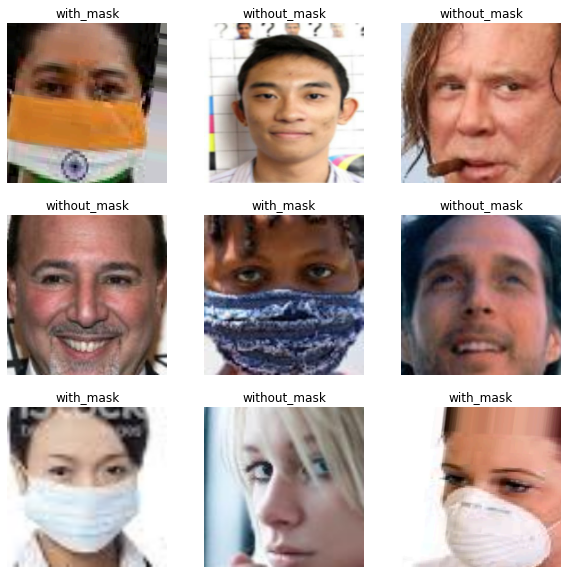

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

2021-09-05 17:07:29.895012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 326 of 1000
2021-09-05 17:07:30.423516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-09-05 17:07:31.808203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


0.0 1.0


In [12]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
391/391 [==============================] - 120s 306ms/step - loss: 0.2273 - accuracy: 0.9199 - val_loss: 0.0749 - val_accuracy: 0.9754
Epoch 2/10
391/391 [==============================] - 118s 301ms/step - loss: 0.1019 - accuracy: 0.9639 - val_loss: 0.0505 - val_accuracy: 0.9805
Epoch 3/10
391/391 [==============================] - 122s 311ms/step - loss: 0.0688 - accuracy: 0.9758 - val_loss: 0.0446 - val_accuracy: 0.9840
Epoch 4/10
391/391 [==============================] - 123s 314ms/step - loss: 0.0574 - accuracy: 0.9783 - val_loss: 0.0373 - val_accuracy: 0.9869
Epoch 5/10
391/391 [==============================] - 124s 317ms/step - loss: 0.0403 - accuracy: 0.9851 - val_loss: 0.0280 - val_accuracy: 0.9901
Epoch 6/10
391/391 [==============================] - 122s 312ms/step - loss: 0.0324 - accuracy: 0.9882 - val_loss: 0.0307 - val_accuracy: 0.9885
Epoch 7/10
391/391 [==============================] - 118s 300ms/step - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0274 -

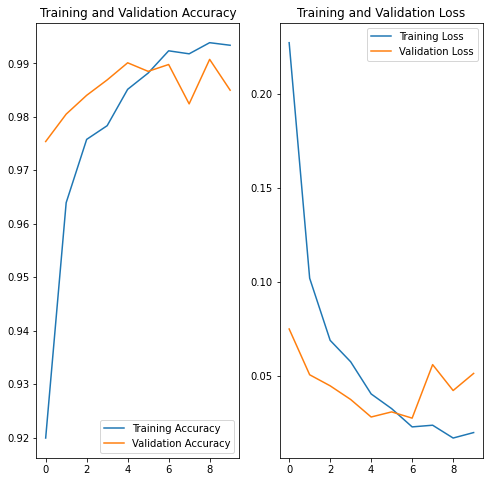

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

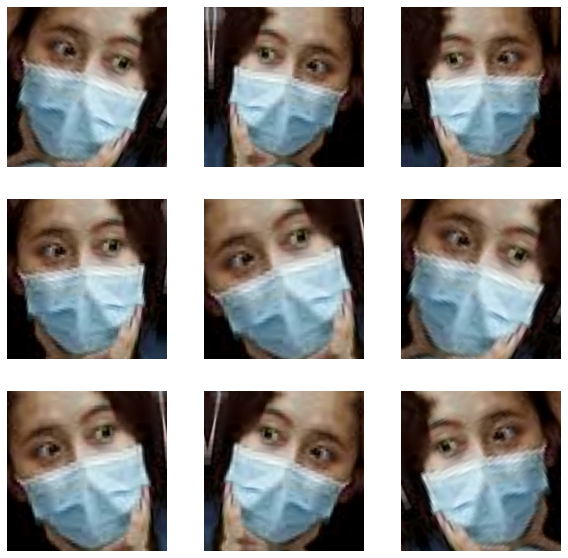

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
391/391 [==============================] - 139s 354ms/step - loss: 0.2286 - accuracy: 0.9116 - val_loss: 0.1302 - val_accuracy: 0.9514
Epoch 2/15
391/391 [==============================] - 137s 349ms/step - loss: 0.1481 - accuracy: 0.9435 - val_loss: 0.0996 - val_accuracy: 0.9645
Epoch 3/15
391/391 [==============================] - 133s 339ms/step - loss: 0.1253 - accuracy: 0.9535 - val_loss: 0.0853 - val_accuracy: 0.9690
Epoch 4/15
391/391 [==============================] - 139s 356ms/step - loss: 0.1087 - accuracy: 0.9606 - val_loss: 0.0536 - val_accuracy: 0.9798
Epoch 5/15
391/391 [==============================] - 136s 348ms/step - loss: 0.0997 - accuracy: 0.9635 - val_loss: 0.0505 - val_accuracy: 0.9808
Epoch 6/15
391/391 [==============================] - 131s 336ms/step - loss: 0.0947 - accuracy: 0.9654 - val_loss: 0.0658 - val_accuracy: 0.9763
Epoch 7/15
391/391 [==============================] - 132s 338ms/step - loss: 0.0814 - accuracy: 0.9703 - val_loss: 0.0479 -

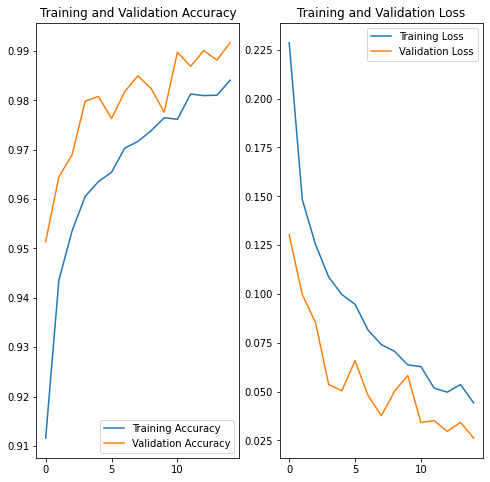

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.save("Face_Mask_Detection.h5")

In [24]:
import cv2
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.load_model("Face_Mask_Detection.h5")
path = 'Testing images/With1.jpg'
img_height = 180
img_width = 180
img = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# img = cv2.imread(path)
# cv2.imshow("Testing image", img)
# cv2.waitKey(0)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 99.96 percent confidence.
